# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
def get_train_val_split(data, train_size=0.8):
    
    total_len = len(data)
    train_len = int(round(train_size*total_len))
    val_len = total_len - train_len

    
    train_set, val_set = torch.utils.data.random_split(data, [train_len, val_len])
    return train_set, val_set


In [3]:
from torch.utils.data import DataLoader
# Define transforms
## YOUR CODE HERE ##
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Create training set and define training dataloader
## YOUR CODE HERE ##
training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_set, val_set = get_train_val_split(training_data, train_size=0.8)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
# Create test set and define test dataloader
## YOUR CODE HERE ##
testing_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(testing_data, batch_size=len(testing_data))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

Three transforms are used in this excersie. 
`ToTensor` is used to transform the image data to tensors so that the pytorch can process.
`flattening` is used in the model object to flatten the tensor to one dimentional so that the linear layer can consume.  
`Normalisation` is used to normalise the images so the values are floating numbers between - and 1 instead of thr original values frm 0 to 255. This will help the gradient descent to update the weighting. It's worth mentioning though the model can still be trained without this normalisation process. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##


def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
        
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


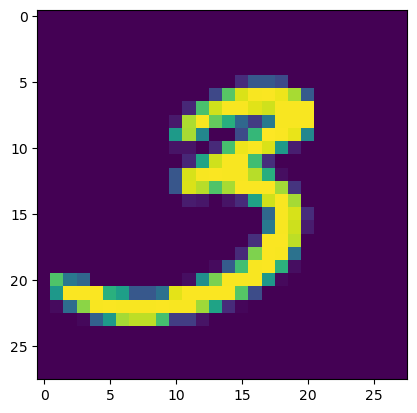

4


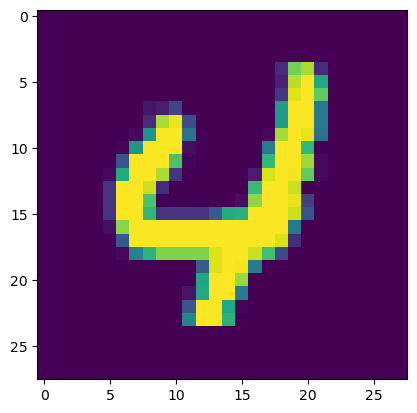

0


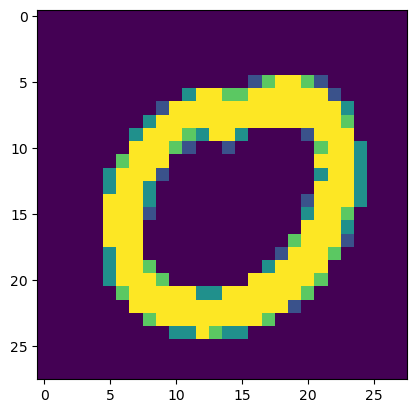

9


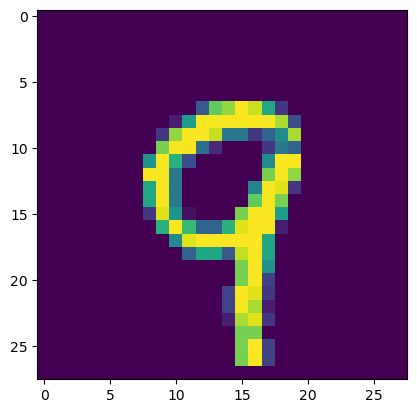

0


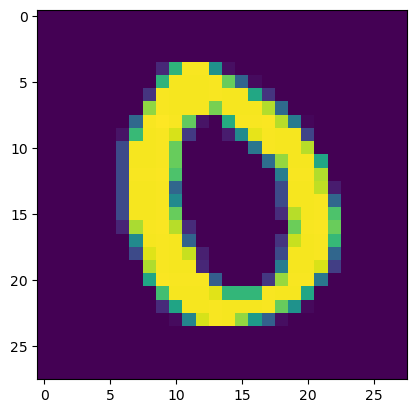

In [5]:
show5(train_loader)

In [6]:
# Explore data
## YOUR CODE HERE ##
print("="*10 + "data set information" + "="*10)
print(train_loader.dataset)
print("="*40)

train_features, train_labels = next(iter(train_loader))

print(f"feature bactch shape: {train_features.shape}")
print(f"label batch shape: {train_labels.shape}")


==========data set information==========
feature bactch shape: torch.Size([64, 1, 28, 28])
label batch shape: torch.Size([64])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
## YOUR CODE HERE ##

class MNIST_MLP(nn.Module):
    def __init__(self):

        super().__init__()
        # self.activation = F.relu
        self.output = F.log_softmax
        self.fc1 = nn.Linear(28 * 28 * 1, 10)
        # self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = torch.flatten(x, 1)
        # x = self.activation(self.fc1(x))
        x = self.output(self.fc1(x), dim=1)
        return x


In [8]:
# Initiate the model
mlp = MNIST_MLP()
mlp.to(device)

MNIST_MLP(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
## YOUR CODE HERE ##

# The chosen loss function and optimizer are specified in the training function below

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##

def train_network_classification(net, train_loader, val_loader):

    num_epochs = 50

    loss_fn = nn.NLLLoss()

    # optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.SGD(net.parameters(), lr=0.01)

    train_loss_history = list()
    train_accuracy_history = list()
    val_loss_history  = list()
    val_accuracy_history = list()

    for epoch in range(num_epochs):

        net.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for i, data in enumerate(train_loader):

            inputs, labels = data

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
            total_train += int(labels.shape[0])

        print(f'Epoch {epoch +1}: ({train_correct}|{total_train}) training accuracy: {train_correct/total_train:.2f} training loss: {train_loss/total_train:.5f}')
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_correct/total_train)

        val_loss = 0.0
        val_correct = 0
        total_val = 0
        net.eval()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = loss_fn(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
            total_val += int(labels.shape[0])

        print(f'Epoch {epoch +1}: ({val_correct}|{total_val}) validation accuracy: {val_correct/total_val:.2f} validation loss: {val_loss/total_val:.5f}')
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_correct/total_val)

    # return training history for each epoch
    return train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history






Plot the training loss (and validation loss/accuracy, if recorded).

In [10]:
def plot_history(train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history):

    plt.subplot()
    plt.plot(train_loss_history, label = "training accuracy")
    plt.plot(val_loss_history, label="validation accuracy")
    plt.title("accuracy")
    plt.legend()
    plt.show()

    plt.subplot()
    plt.plot(train_accuracy_history, label = "training accuracy")
    plt.plot(val_accuracy_history, label="validation accuracy")
    plt.title("accuracy")
    plt.legend()
    plt.show()

Epoch 1: (37747|48000) training accuracy: 0.79 training loss: 0.01668
Epoch 1: (10204|12000) validation accuracy: 0.85 validation loss: 0.01067
Epoch 2: (41312|48000) training accuracy: 0.86 training loss: 0.00931
Epoch 2: (10438|12000) validation accuracy: 0.87 validation loss: 0.00836
Epoch 3: (41948|48000) training accuracy: 0.87 training loss: 0.00786
Epoch 3: (10537|12000) validation accuracy: 0.88 validation loss: 0.00744
Epoch 4: (42282|48000) training accuracy: 0.88 training loss: 0.00716
Epoch 4: (10631|12000) validation accuracy: 0.89 validation loss: 0.00691
Epoch 5: (42543|48000) training accuracy: 0.89 training loss: 0.00673
Epoch 5: (10684|12000) validation accuracy: 0.89 validation loss: 0.00656
Epoch 6: (42688|48000) training accuracy: 0.89 training loss: 0.00643
Epoch 6: (10704|12000) validation accuracy: 0.89 validation loss: 0.00631
Epoch 7: (42840|48000) training accuracy: 0.89 training loss: 0.00621
Epoch 7: (10752|12000) validation accuracy: 0.90 validation loss: 

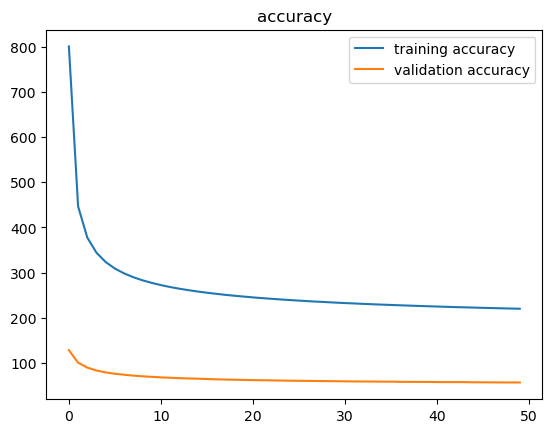

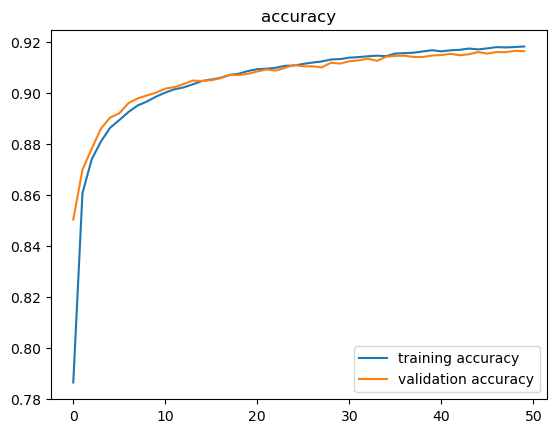

In [11]:
## YOUR CODE HERE ##
train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history = train_network_classification(mlp, train_loader, val_loader)
plot_history(train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
## YOUR CODE HERE ##

def test_network_classification(net, test_loader):

    loss_fn = nn.NLLLoss()
    test_loss = 0.0
    test_correct = 0
    total_test = 0
    net.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
        total_test += int(labels.shape[0])

    print(f'test set accuracy: {test_correct/total_test:.2f} test set loss: {test_loss/len(test_loader):.5f}')



In [13]:
test_network_classification(mlp, test_loader)

test set accuracy: 0.92 test set loss: 56.32909


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
## YOUR CODE HERE ##
class MNIST_MLP(nn.Module):
    def __init__(self):

        super().__init__()
        self.activation = F.relu
        self.output = F.log_softmax
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim=1)
        return x



Epoch 1: (22780|48000) training accuracy: 0.47 training loss: 0.03125
Epoch 1: (8642|12000) validation accuracy: 0.72 validation loss: 0.01974
Epoch 2: (38549|48000) training accuracy: 0.80 training loss: 0.01214
Epoch 2: (10213|12000) validation accuracy: 0.85 validation loss: 0.00854
Epoch 3: (41633|48000) training accuracy: 0.87 training loss: 0.00739
Epoch 3: (10602|12000) validation accuracy: 0.88 validation loss: 0.00649
Epoch 4: (42678|48000) training accuracy: 0.89 training loss: 0.00607
Epoch 4: (10789|12000) validation accuracy: 0.90 validation loss: 0.00571
Epoch 5: (43235|48000) training accuracy: 0.90 training loss: 0.00544
Epoch 5: (10803|12000) validation accuracy: 0.90 validation loss: 0.00527
Epoch 6: (43550|48000) training accuracy: 0.91 training loss: 0.00503
Epoch 6: (10910|12000) validation accuracy: 0.91 validation loss: 0.00491
Epoch 7: (43828|48000) training accuracy: 0.91 training loss: 0.00472
Epoch 7: (10961|12000) validation accuracy: 0.91 validation loss: 0

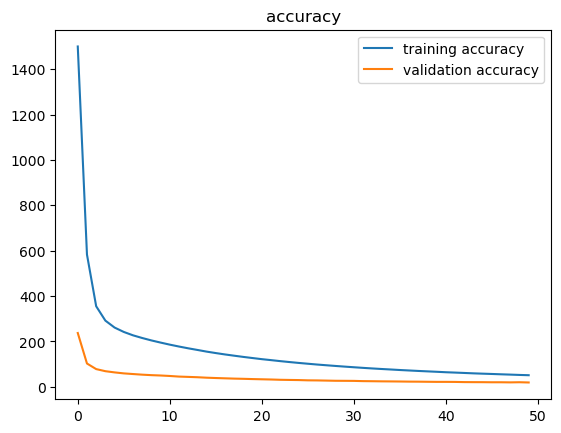

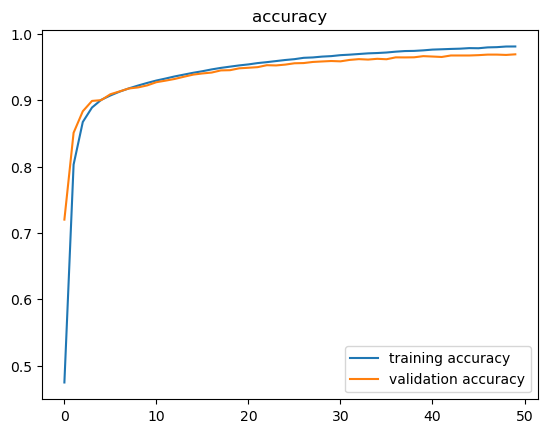

In [15]:
## YOUR CODE HERE ##
mlp_multilayer = MNIST_MLP()
mlp_multilayer.to(device)
train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history = train_network_classification(mlp_multilayer, train_loader, val_loader)
plot_history(train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history)

In [16]:
test_network_classification(mlp_multilayer, test_loader)

test set accuracy: 0.97 test set loss: 18.91382


## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
## YOUR CODE HERE ##

torch.save(mlp.state_dict(), 'model.pt')